# FWI modelo SEG/EAGE

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering, HDF5, Dates, DelimitedFiles

In [2]:
n,d,o,m0,m = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "n", "d", "o", "m0", "m")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);

In [3]:
M = load("model_overthrust_fwi_result_low_f.jld");

In [4]:
v0 = sqrt.(1f0 ./ m0)
vmin = ones(Float32, model0.n) .* 1.3f0
vmax = ones(Float32, model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21];
# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
# Load data
block = segy_read("$(JUDI.JUDI_DATA)/overthrust_shot_records.segy")
d_obs = judiVector(block)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7076688, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geopc3/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


judiVector{Float32, Matrix{Float32}} with 16 sources


In [6]:
# Set up wavelet
src_geometry = Geometry(block; key="source")
wavelet = ricker_wavelet(src_geometry.t[1],src_geometry.dt[1],0.008f0)  # 8 Hz wavelet
q = judiVector(src_geometry,wavelet)

judiVector{Float32, Matrix{Float32}} with 16 sources


In [7]:
F0 = judiModeling(deepcopy(model0), src_geometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [8]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations)
m0_values = zeros(length(model0.m), niterations);

In [9]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [10]:
# Main loop
t1 = now();
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end
t2 = now();

FWI iteration no: 1; function value: 521676.0
(α, misfit) = 

Building forward operator
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.04 s
Building adjoint born operator
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 

(0.1f0, 334767.59375)


Building forward operator
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 2; function value: 334870.5
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 980074.875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.039398909727221286, 580107.6875)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s


(0.013065319871038867, 171484.71875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


FWI iteration no: 3; function value: 171534.22
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 166545.9375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


FWI iteration no: 4; function value: 166594.38
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 987986.5625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.035779758928296865, 501165.53125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.010184830812137996, 84523.90625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


FWI iteration no: 5; function value: 84711.055
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 598336.8125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.023402619470936355, 109319.25)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.03 s


(0.008795853056470045, 69408.0)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 6; function value: 69474.53
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 284256.34375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.024021645606035126, 66446.8203125)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


7; function value: 66513.47


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 987464.125)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.017894022224341527, 95255.7578125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.07 s


(α, misfit) = (0.006414354856865529, 52833.01171875)
FWI iteration no: 

Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


8; function value: 52902.465


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 95237.2578125)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.03669549996387137, 49128.44921875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


FWI iteration no: 9; function value: 49209.633
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 808048.375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.018730750791508505, 118727.3828125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.004667512640865976, 40466.78125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 10; function value: 40547.918
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.09 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 76613.8828125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.035894240558441676, 38615.53515625)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


11; function value: 38703.516


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 957866.0625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.013863204851745366, 60906.37890625)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.00452274058578021, 32260.921875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


12; function value: 32348.4


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 65755.6640625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


(0.03488376234350186, 31711.23046875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 13; function value: 31794.775
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 858366.3125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.013758377201988302, 60569.1328125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.003877975814592496, 26885.63671875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 14; function value: 26968.914
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 106903.5625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.02375131908694632, 27760.19921875)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.010794054281016057, 25729.6484375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 15; function value: 25813.215
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 287709.03125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.012166892960713317, 26791.857421875)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.005417646222127164, 24870.193359375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 16; function value: 24953.742
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 132371.859375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.019277321305947736, 26197.984375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.008419299593802, 24204.263671875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 17; function value: 24280.256
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 265479.09375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


(α, misfit) = (0.012188229759760128, 25291.876953125)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.005367662392746904, 23484.662109375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 18; function value: 23560.787
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 137442.546875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.018238201829744526, 24885.96484375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.007866481097204977, 22911.998046875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 19; function value: 22988.018
(α, misfit) = 

Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 253494.46875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.012123184836274812, 24007.9921875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.00530243438822683, 22272.025390625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


FWI iteration no: 20; function value: 22348.246
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.11 s
Operator `gradient` ran in 0.

(0.1f0, 136895.34375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.0177308398709509, 23684.90625)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.007593214973725937, 21767.955078125)


Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


FWI iteration no: 21; function value: 21844.174
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.10 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 244689.625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.012009874567016396, 22863.037109375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.0052222730630691735, 21193.72265625)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 22; function value: 21270.064
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 135622.421875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.017332689521506673, 22611.625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.0073745135047581754, 20748.0)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


FWI iteration no: 23; function value: 20824.305
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.09 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 238051.984375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.011868475332726523, 21838.490234375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


(0.005133371001425677, 20228.61328125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


FWI iteration no: 24; function value: 20304.97
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `gradient` ran in 0.

(0.1f0, 133852.65625)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.017017321750960157, 21647.3984375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.007197088162068727, 19832.66015625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 25; function value: 19908.922
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 233027.65625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.011707284844654954, 20915.66015625)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.005038974541888327, 19360.0078125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 26; function value: 19436.504
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 131724.3125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.016767276764775553, 20777.462890625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.0070519347238985975, 19007.19140625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


FWI iteration no: 27; function value: 19083.582
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 229360.109375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.011529758914116586, 20080.5703125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s


(0.004940433226493649, 18574.392578125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 28; function value: 18650.992
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 129436.8515625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.016563120202682257, 19989.353515625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.006929633479182223, 18259.484375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 29; function value: 18336.023
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.13 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 226650.078125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.011344690323827861, 19321.259765625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.004841465980675928, 17860.91015625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 30; function value: 17937.498
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.09 s
Operator `gradient` ran in 0.10 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 126991.7109375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.016400741574679398, 19254.814453125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.006841147039730615, 17580.068359375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s


In [11]:
fwi = sqrt.(1f0./adjoint(model0.m)).data;
v0 = sqrt.(1f0./M["m0"]);
v = sqrt.(1f0./m)';

In [12]:
for a=1:32
    fig=figure(figsize=(7,4), dpi=300);
    if a <=2
        im = imshow(v0', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
        title(L"Modelo inicial $\mathbf{m_0}$")
    else
        fwi_ = sqrt.(1f0./adjoint(reshape(m0_values[:, a-2], (401,121))));
        im = imshow(fwi_, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
        title("FWI High fq - iteración:"*string(a+28))
    end
    cb = colorbar(im, pad=0.01)
    cb[:set_label](label = L"$V_p [km/s]$")
    xlabel(L"Posición horizontal $[m]$")
    ylabel(L"Profundidad $[m]$")
    savefig("fwi_h_results/fwi"*string(a+32)*".jpeg",format="jpeg", dpi=300);
    plt.close()
end

/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


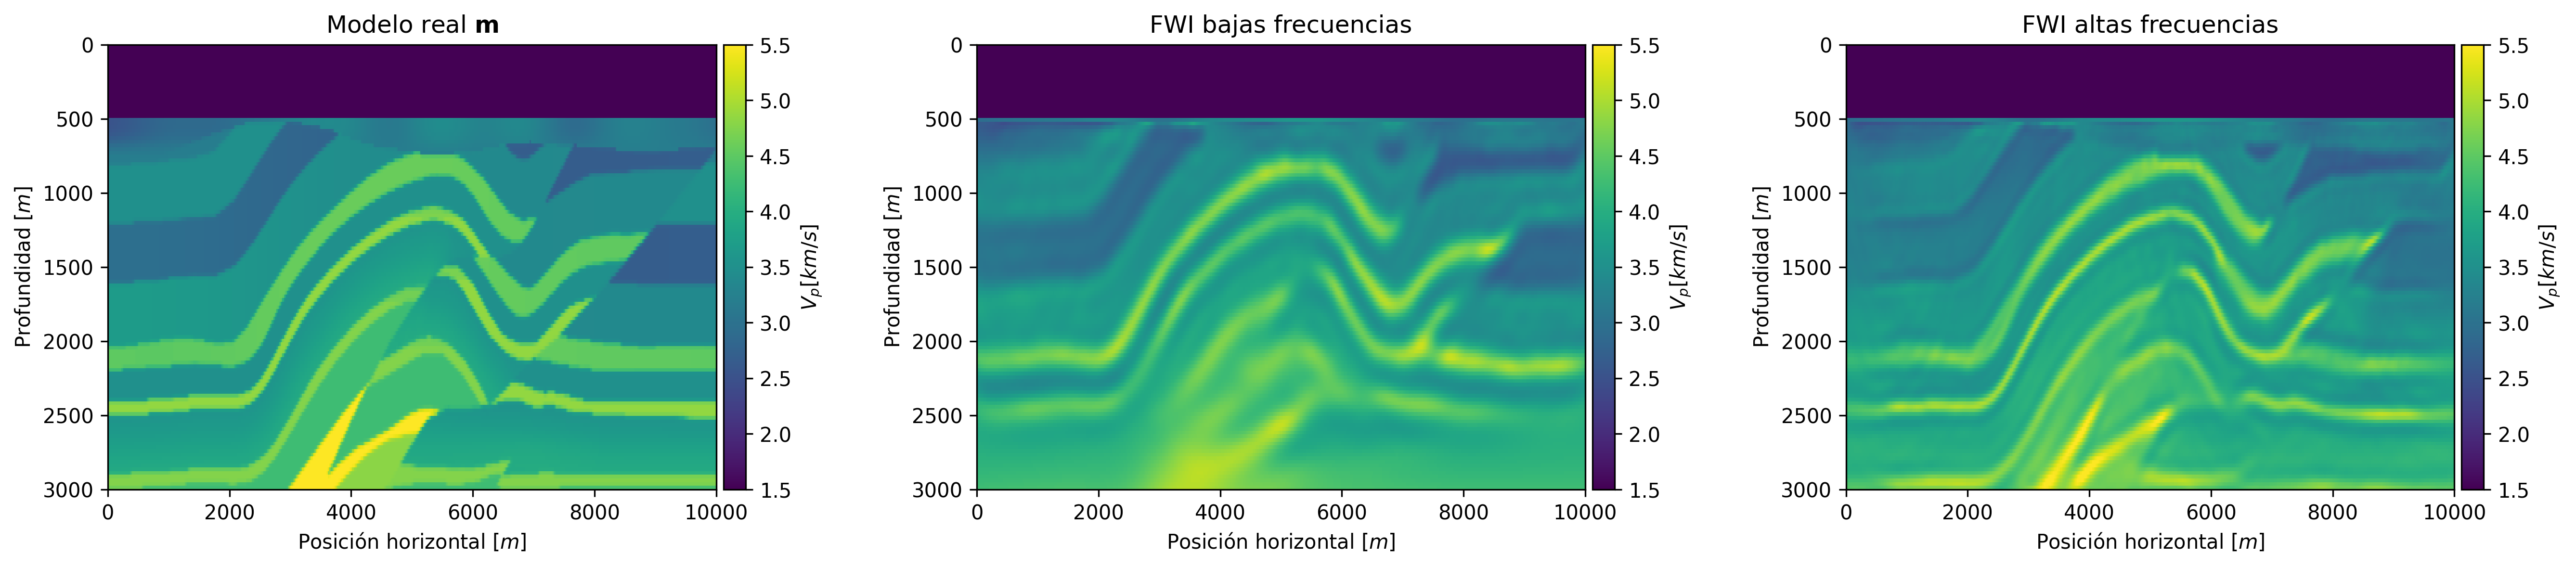

In [54]:
fig=figure(figsize=(22,4), dpi=300);
subplot(131)
im = imshow(v, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI bajas frecuencias")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI altas frecuencias")
display(fig)

In [66]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi).^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 121 and 401

In [15]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi)) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

DimensionMismatch: DimensionMismatch: dimensions must match: a has dims (Base.OneTo(121), Base.OneTo(401)), b has dims (Base.OneTo(401), Base.OneTo(121)), mismatch at 1

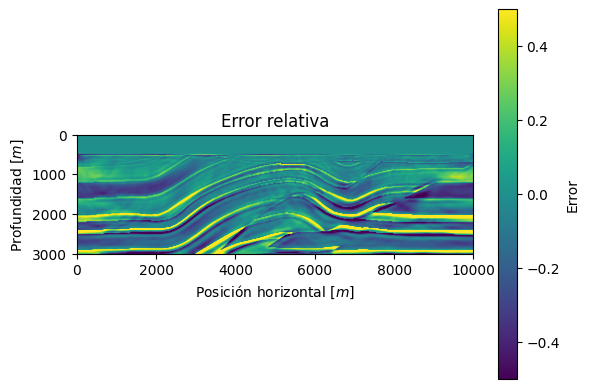

In [16]:
difs = v-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-0.5, vmax=0.5)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

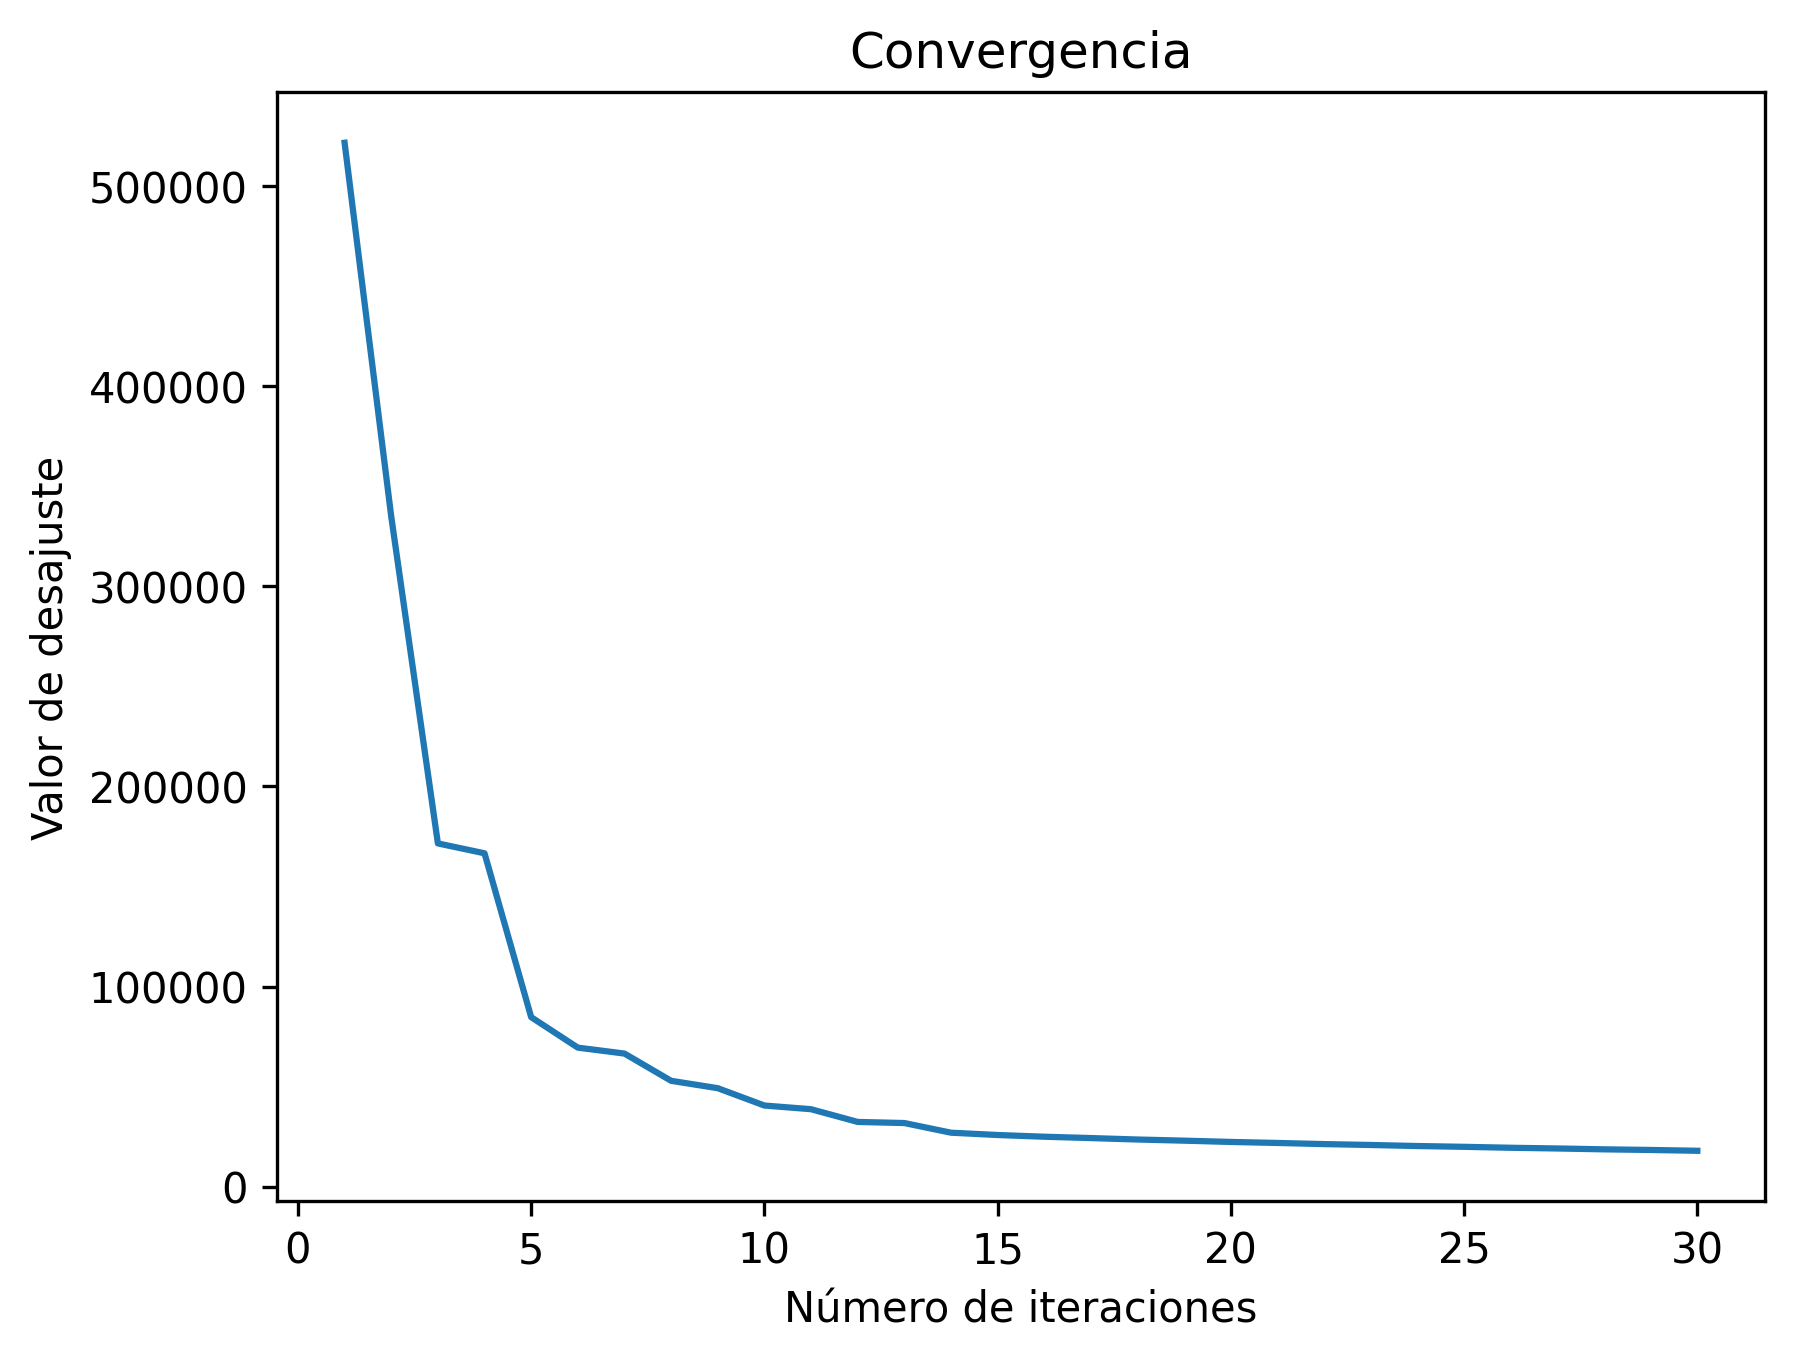

In [17]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [18]:
dm = m - m0;

In [19]:
save("model_overthrust_fwi_result_high_f.jld", "n", M["n"], "d", M["d"], "o", M["o"], "m", M["m"], "m0", model0.m.data, "dm", dm)

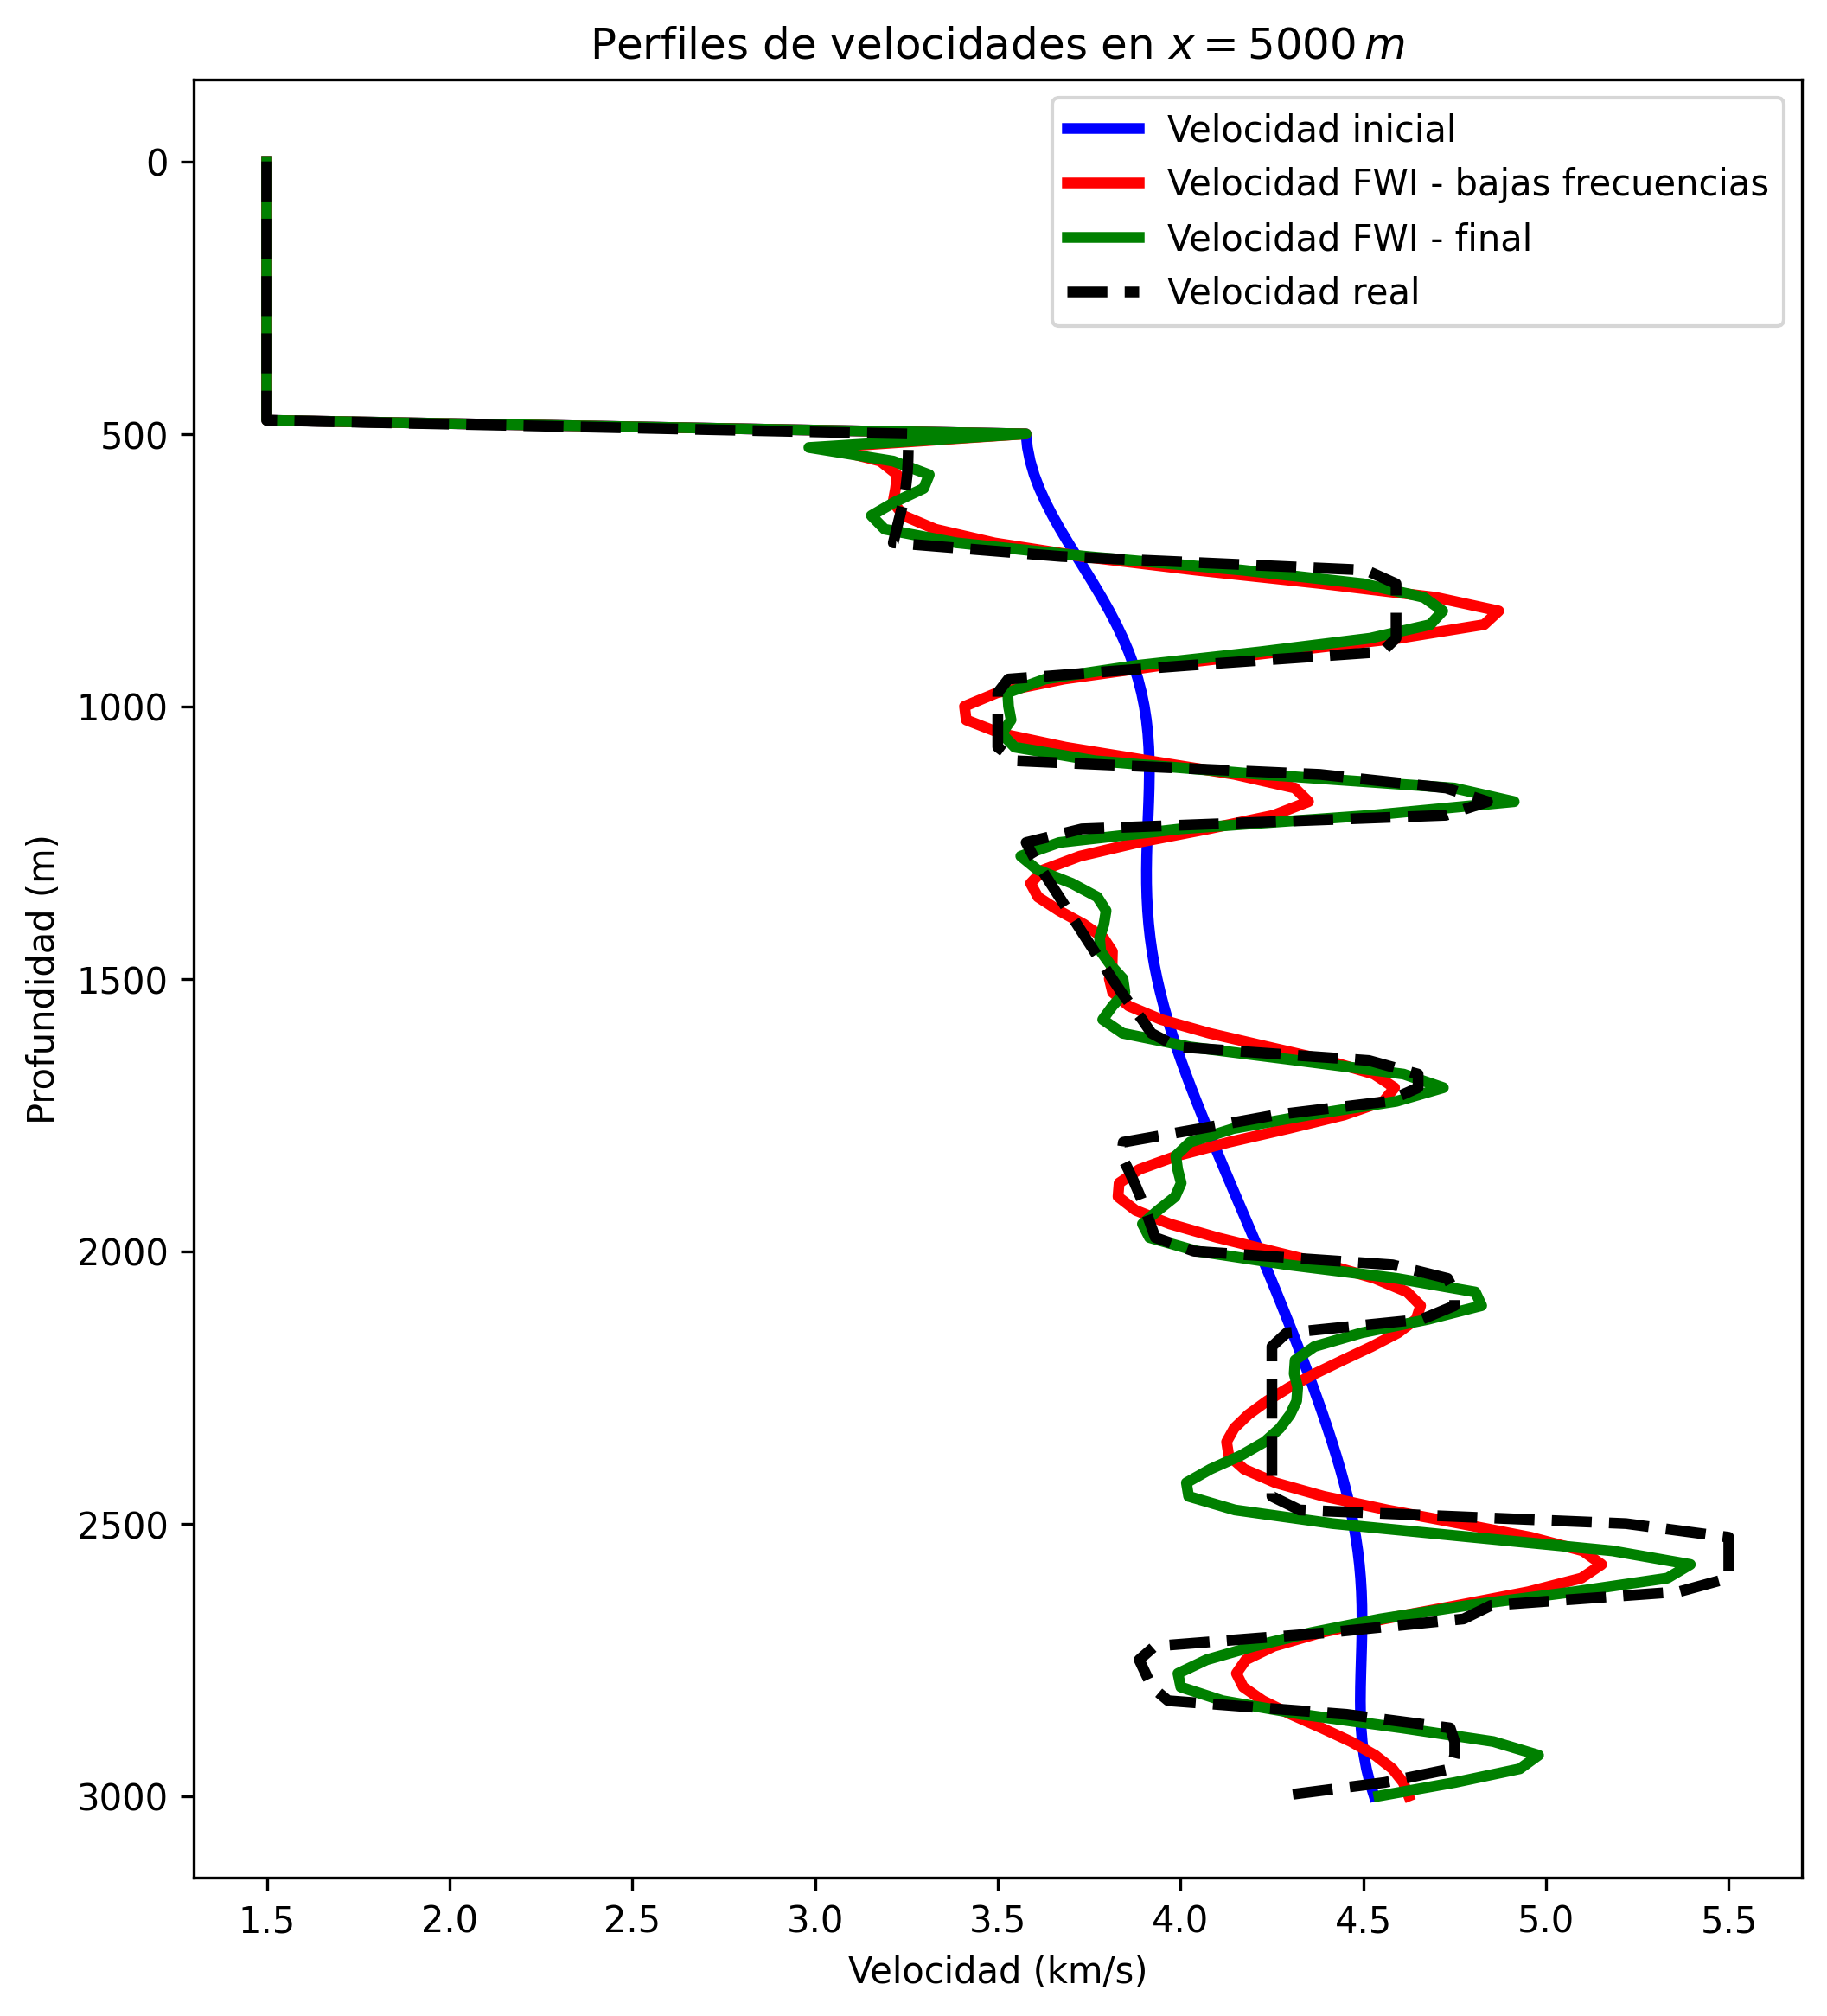

In [69]:
profile = 201
fig = figure(figsize=(8,9), dpi=300)
xax = range(0, stop=3000, step=25)
plot(sqrt.(1 ./ adjoint(m0))[:,profile], xax, linewidth=3, label="Velocidad inicial", "b")
plot(v0[profile,:], xax, linewidth=3, label="Velocidad FWI - bajas frecuencias", "r")
plot(fwi[:,profile], xax, linewidth=3, label="Velocidad FWI - final", "g")
plot(v[:,profile], xax, linewidth=3, label="Velocidad real", "k--")
legend()
gca().invert_yaxis()
ylabel("Profundidad (m)")
xlabel("Velocidad (km/s)")
title(latexstring("Perfiles de velocidades en \$x=$((profile-1)*25)\\,m\$"))
display(fig)

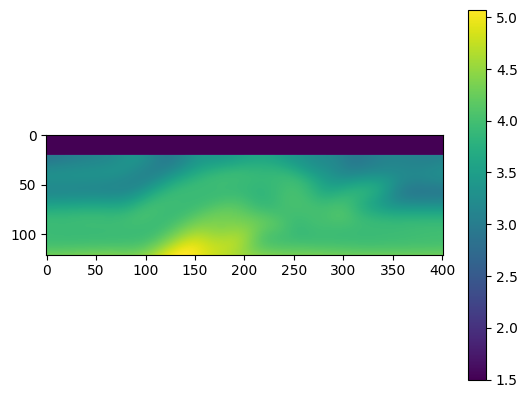

In [21]:
fig = figure()
imshow(sqrt.(1 ./ adjoint(m0)))
colorbar()
display(fig)

In [22]:
writedlm("fwi_h_results/m0.txt", v0)
writedlm("fwi_h_results/fwi.txt", m0_values)
writedlm("fwi_h_results/mtrue.txt", v)
writedlm("fwi_h_results/fval.txt", fhistory_SGD)

In [23]:
canonicalize(t2 - t1)

3 minutes, 16 seconds, 377 milliseconds

In [24]:
t2 - t1

196377 milliseconds